## Setting up network

Loading models

In [67]:
from model import GraphMatchingNetwork, GraphConvolutionNetwork
import torch

# Load checkpoint (full)
# filename = f'./checkpoints/gmn_glad-bird-6.pth.tar'
filename = f'./checkpoints/gcn_frosty-tree-7.pth.tar'
# filename = f'./checkpoints/gmn_decent-smoke-17.pth.tar'
checkpoint = torch.load(filename, map_location=lambda storage,
                        loc: storage.cuda() if torch.cuda.is_available() else storage.cpu())

# Retrieve state dict and configurations
state_dict = checkpoint['state_dict']
cfg = checkpoint['config']

# Initialize model
if cfg.model.name == "gmn": model = GraphMatchingNetwork(cfg)
elif cfg.model.name == "gcn": model = GraphConvolutionNetwork(cfg)
else: raise ValueError("Only GMNs and GENs are implemented")

# Print some information
print(cfg.model.name)

# Load weights (state dict) into the model
model.load_state_dict(state_dict)  # should output "<All keys matched successfully>"

gcn


<All keys matched successfully>

## Sample graphs

Generate two random graphs for testing

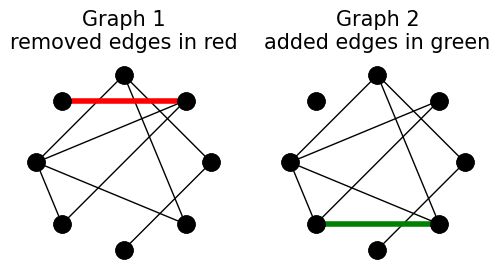

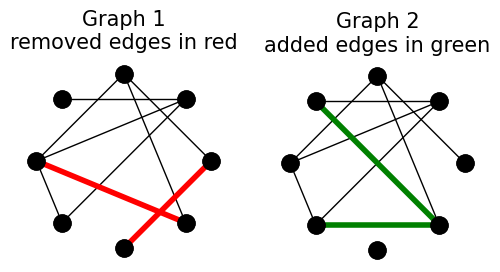

In [68]:
from data import generate_binomial_graph
from data import substitute_random_edges
from plot import plot_difference_graphs

# Graph distribution (small graphs)
N = 8
pe = 0.2
kp = 1
kn = 2

# Generate a pair of graphs
G1,_ = generate_binomial_graph(N, pe=pe)
G2 = substitute_random_edges(G1, k=kp)
G3 = substitute_random_edges(G1, k=kn)

# Plot both graphs
fs = 3
node_size = fs*50
edge_size = fs/3

plot_difference_graphs(G1, G2, fs=fs, fs_title=5, node_size=node_size, edge_size=edge_size)
plot_difference_graphs(G1, G3, fs=fs, fs_title=5, node_size=node_size, edge_size=edge_size)

## Feedforward

In [77]:
import networkx as nx
from torch_geometric.utils import from_networkx

def inference(graphs, model):

    # Set model to evaluation mode
    model.eval()

    # Combine two graphs into a disjoint
    G = nx.disjoint_union_all(graphs)
    G = from_networkx(G)

    # Prepare data
    edge_index = G['edge_index']  # edge index
    node_feats = torch.ones(G.num_nodes, cfg.model.node_dim)  # node features to all-ones
    edge_feats = torch.ones(G.num_edges, cfg.model.edge_dim)  # edge features to all-ones
    batch_id = torch.cat([
            i*torch.ones(graphs[i].number_of_nodes(), dtype=torch.int64)
                for i in range(len(graphs))],
        dim=0)

    # Get node features
    with torch.no_grad():
        return model(edge_index, x1=node_feats, x2=None, edge_feats=edge_feats, batch=batch_id)

Inference step on two graphs

In [78]:
# Combine graphs
graphs = [G1, G2, G1, G3]

# Compute node and graph output features
node_feats, graph_feats = inference(graphs, model)

# Print some information
print(f"## Shape node features:\n{node_feats.shape}\n\n"
      f"## Shape graph features:\n{graph_feats.shape}")

## Shape node features:
torch.Size([32, 32])

## Shape graph features:
torch.Size([4, 128])


In [79]:
print(graph_feats)

tensor([[ 0.6326, -1.3850,  0.7564, -0.6483, -1.2542, -1.1257, -0.5661,  0.5878,
         -1.3676, -0.8624, -1.1959, -1.0449, -1.4780, -0.7744,  1.1015, -0.8778,
          1.1268,  0.9784,  1.1185,  0.7215, -0.9350,  0.7218,  0.7935, -1.4202,
          1.1336, -1.1418,  1.0029, -0.5572, -1.2097,  0.8623, -1.0618,  0.7823,
         -0.8284,  0.9768,  0.9358,  1.0885, -0.7626,  0.6356,  0.8792,  0.4346,
          1.1262, -1.1415, -1.1399,  1.0629, -0.8488,  1.0528,  1.2344,  0.9793,
          1.1658, -0.7601, -1.2493,  0.5718, -0.9295,  1.2902,  1.3114,  0.7142,
         -0.6790, -0.6521, -1.2512,  1.0324,  1.1256,  1.0197,  1.0600,  0.5430,
          1.1316, -1.3090, -1.0268, -0.9815,  1.2188, -0.4644, -0.8666, -0.7947,
         -1.1916,  0.9192,  0.8735,  1.0895, -0.3580, -0.8204,  0.4431, -0.9455,
         -0.8186, -0.7800,  1.3281, -1.1636,  0.8211,  0.9483, -1.3811,  1.5276,
         -1.0318,  0.9571, -1.1154, -0.8918,  0.4581, -1.2325, -0.8252, -0.8102,
         -0.8687, -0.7722, -

## Plot features

In [58]:
from plot import set_figure
import numpy as np

def set_aspect_ratio(ax, ratio=1.0):

    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

def plot_node_features(node_feats, N, layer=5, **kwargs):

    # Global settings
    fs = 8
    fc = "white"
    tc = "white" if fc == "black" else "black"

    # Set figure
    fig, axs = set_figure(1, 2, fs=fs, fs_title=3, fs_axes=2.5, fs_xtick=2, fs_ytick=2, fc=fc, **kwargs)
    # fig.suptitle("Node output features")

    x = node_feats[:N]
    y = node_feats[N:N*2]

    # Loop through data
    for i, data in enumerate([x, y]):

        # Set axis index
        ax = axs[i]

        # Make up axis
        ax.spines['bottom'].set_color(tc)
        ax.spines['left'].set_color(tc)
        ax.tick_params(axis='x', colors=tc)
        ax.tick_params(axis='y', colors=tc)

        # Plot features
        ax.plot(np.array(data.t()))

        # Set axis labels
        ax.axis(True)
        ax.set_ylabel(f"Value", color=tc)
        ax.set_xlabel(f"Feature index", color=tc)

        # Set axis title
        ax.set_title(f"Graph {i+1} @ Layer {layer}")

         # Set aspect
        set_aspect_ratio(ax, ratio=0.25)

def plot_graph_features(graph_feats, **kwargs):

    # Global settings
    fs = 8
    fc = "white"
    tc = "white" if fc == "black" else "black"

    # Set figure
    fig, axs = set_figure(1, 2, fs=fs, fs_title=3, fs_axes=2.5, fs_xtick=2, fs_ytick=2, fc=fc, **kwargs)
    # fig.suptitle("Graph output features")

    x = graph_feats[0]
    y = graph_feats[1]

    # Loop through data
    for i, data in enumerate([x, y]):

        # Set axis index
        ax = axs[i]

        # Make up axis
        ax.spines['bottom'].set_color(tc)
        ax.spines['left'].set_color(tc)
        ax.tick_params(axis='x', colors=tc)
        ax.tick_params(axis='y', colors=tc)

        # Plot features
        ax.plot(data)

        # Set axis labels
        ax.axis(True)
        ax.set_ylabel(f"Value", color=tc)
        ax.set_xlabel(f"Feature index", color=tc)

        # Set axis title
        ax.set_title(f"Graph {i+1}")

        # Set aspect
        set_aspect_ratio(ax, ratio=0.25)

Eucl. distance between graph features:	2.5568246841430664
Eucl. distance between graph features:	0.11754869669675827


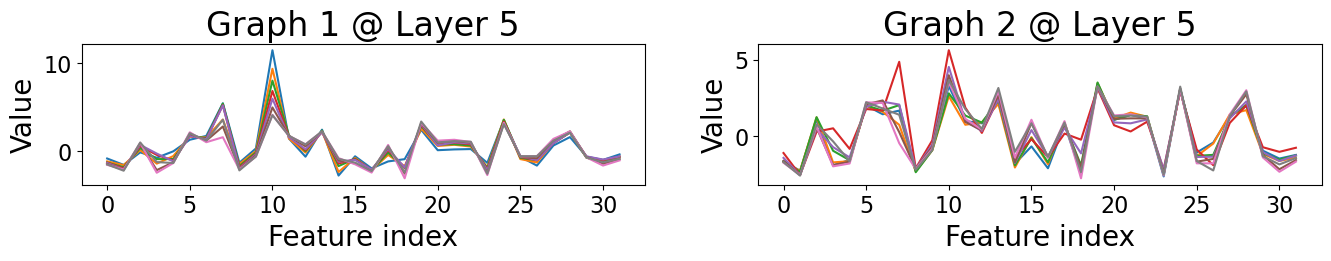

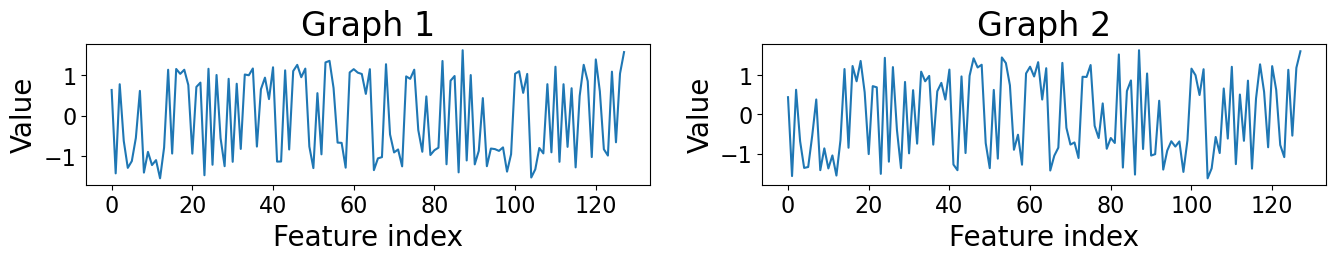

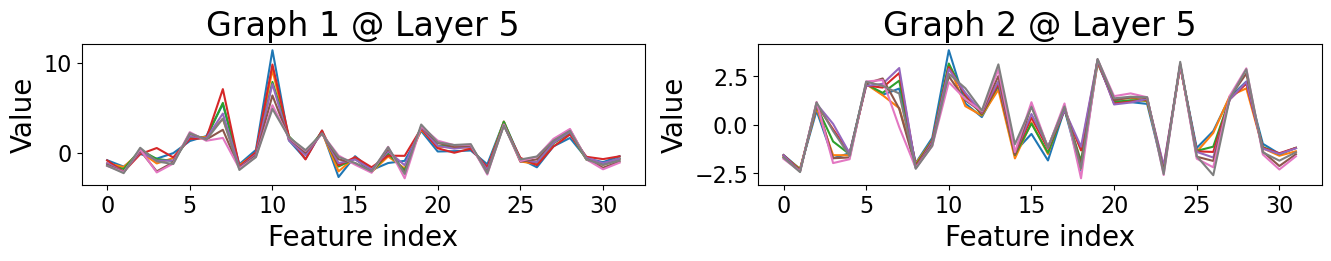

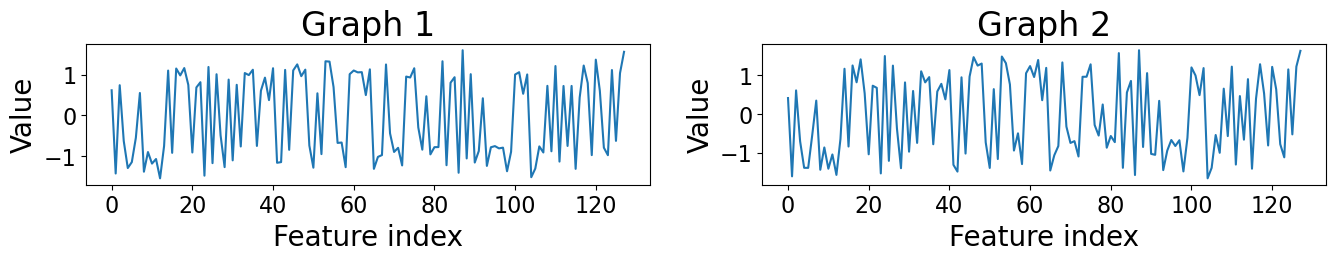

In [111]:
from metrics import euclidean_distance

# Generate a pair of graphs
G1,_ = generate_binomial_graph(N, pe=pe)
G2 = substitute_random_edges(G1, k=kp)
# G3 = substitute_random_edges(G1, k=kn)

# Combine graphs
graphs = [G1, G2]

# Compute node and graph output features
node_feats, graph_feats = inference(graphs, model)
plot_node_features(node_feats, N, layer=5)
plot_graph_features(graph_feats)
x1, y1 = graph_feats[0], graph_feats[1]
print(f"Eucl. distance between graph features:\t{euclidean_distance(x1, y1)}")

# Combine graphs
graphs = [G2, G1]

# Compute node and graph output features
node_feats, graph_feats = inference(graphs, model)
plot_node_features(node_feats, N, layer=5)
plot_graph_features(graph_feats)
x2, y2 = graph_feats[0], graph_feats[1]
print(f"Eucl. distance between graph features:\t{euclidean_distance(x1, x2)}")